In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [12]:
!if [ -d deepflows ]; then rm -Rf deepflows; fi
!git clone https://github.com/CDGlissov/recurrent-flows-msc.git deepflows
!pip install "./deepflows"

Cloning into 'deepflows'...
remote: Enumerating objects: 112, done.
remote: Total 112 (delta 0), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (112/112), 690.41 KiB | 1.70 MiB/s, done.
Resolving deltas: 100% (47/47), done.
Processing ./deepflows
  Created wheel for recurrent-flows-msc: filename=recurrent_flows_msc-0.1.0-cp36-none-any.whl size=1121 sha256=bdd6b0c797ed28511af9e9bb56155f56c49bf377f9079cddc0b3a467ef52733f
  Stored in directory: /tmp/pip-ephem-wheel-cache-gd4dhgnj/wheels/f0/5a/77/8518120597d432632c6abe1aa892d29d8c308fccf620551d65
Successfully built recurrent-flows-msc
  Found existing installation: recurrent-flows-msc 0.1.0
    Uninstalling recurrent-flows-msc-0.1.0:
      Successfully uninstalled recurrent-flows-msc-0.1.0


In [13]:
from deepflows.data_generators import celeba
from deepflows import utils
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import IPython
import os
import pandas as pd
from scipy import linalg as la
from math import log, pi, exp

device = utils.set_gpu(True)

Note: GPU is available


# Data

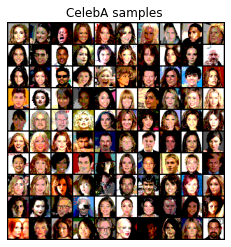

In [14]:
train_data, test_data = celeba.get_celeba(plot_sample=True)

'''
Function transforming CelebA data to conditioned CelebA dataset
'''
def get_joint_conditioned_data(data, box_size = (8, 24)):
  i, j = box_size
  x = data.copy()
  y = data.copy()
  h, w=data.shape[-2:]

  # Set the inner square to 0
  x[:, :, i:j, i:j] = 0
  
  # Set the outer square to 0
  get_ids = np.concatenate((np.arange(0, i, 1),np.arange(j, w, 1)))
  y[:, :, get_ids, :] = 0
  y[:, :, :, get_ids] = 0

  return np.concatenate((x, y), axis=1)

conditioned_train_set = get_joint_conditioned_data(train_data)
conditioned_test_set = get_joint_conditioned_data(test_data)

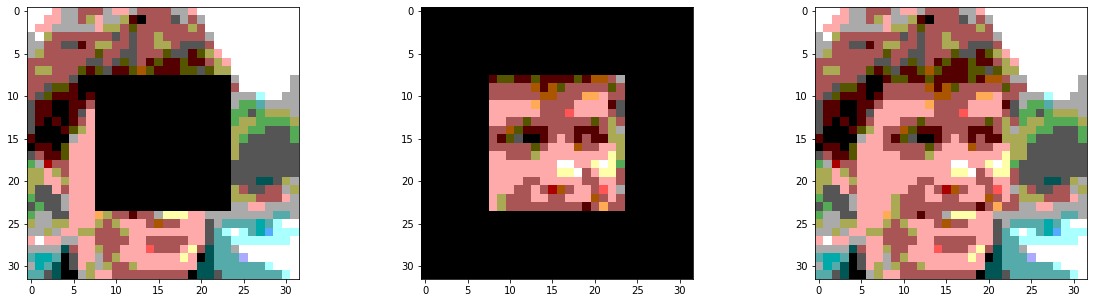

In [15]:
x, y = torch.tensor(conditioned_train_set).split(3,1)
x = x[8]
y = y[8]
fig, ax = plt.subplots(1, 3, figsize = (20,5))
ax[0].imshow((x/x.max()).permute(1,2,0))
ax[1].imshow((y/y.max()).permute(1,2,0))
ax[2].imshow(((y+x)/(y+x).max()).permute(1,2,0))
plt.show()

## Glow

# Conditional Glow

#### Nets

In [16]:
logabs = lambda x: torch.log(torch.abs(x))

class ConditionResnet(nn.Module):
    def __init__(self, in_channels=3,d=2):
        super(ConditionResnet, self).__init__()
        self.in_channels=in_channels
        self.d=d
        layers = [WeightNormConv2d(in_channels, in_channels, (2, 2), stride=2, padding=0),
                  nn.ReLU(),
                  WeightNormConv2d(in_channels, in_channels, (2, 2), stride=2, padding=0),
                  nn.ReLU(),
                  WeightNormConv2d(in_channels, in_channels, (2, 2), stride=2, padding=0),
                  nn.ReLU()]
        layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)
        layersFW=[nn.Linear(4 *4*3,32),nn.ReLU(),nn.Linear(32,32),nn.ReLU(),nn.Linear(32,in_channels*d)]
        layersFW.append(nn.Tanh())
        self.netFW = nn.Sequential(*layersFW)

    def forward(self, x):
        bss=x.shape[0]
        x=self.net(x)
        x=x.view(bss,-1)
        x=self.netFW(x)
        x=x.view(bss,-1,1,1)

        return x

class ConditionalInvConv(nn.Module):
    def __init__(self, n_channels):
        super(ConditionalInvConv, self).__init__()
        self.ConditionalNet = ConditionResnet(in_channels=n_channels, d=n_channels)
        self.n_channels = n_channels
        self.initialized = False

    def forward(self, x,condition, reverse=False):
        B,C,H,Wi = x.size()

        W=self.ConditionalNet(condition)
        W=W.view(B,self.n_channels,self.n_channels)
        logdet=torch.slogdet(W)[1]
        W = W.view(B, self.n_channels,self.n_channels,1,1)

        x = x.reshape(1, B*C,H,Wi) # this reshape might be sketchy...
        B_k, C_i_k, C_o_k, H_k, W_k = W.size()

        W = W.view(B_k*C_i_k,C_o_k,H_k,W_k)
        
        if reverse:
          W=W.view(B,self.n_channels,self.n_channels)
          W=torch.inverse(W.double()).float().view(B, self.n_channels,self.n_channels,1,1)
          W = W.reshape(B_k*C_i_k, C_o_k, H_k, W_k) 
          out=F.conv2d(x, W, groups=B)
          out=out.view(B, C, H, Wi)
        else:
          out = F.conv2d(x, W,groups=B)
          out=out.view(B,C,H,Wi)
        return out, logdet.view(B,1,1,1)

class WeightNormConv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size, stride=1, padding=0,
                 bias=True):
        super(WeightNormConv2d, self).__init__()
        self.conv = nn.utils.weight_norm(
            nn.Conv2d(in_dim, out_dim, kernel_size,
                      stride=stride, padding=padding, bias=bias))

    def forward(self, x):
        return self.conv(x)


class ConditionalActNorm(nn.Module):
    def __init__(self, n_channels):
        super(ConditionalActNorm, self).__init__()
        self.ConditionalNet=ConditionResnet(in_channels=n_channels,d=2)
        self.log_scale = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.shift = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.n_channels = n_channels
        self.initialized = False

    def forward(self, x,condition, reverse=False):
        log_scale,shift=self.ConditionalNet(condition).split(self.n_channels,dim=1)
        if reverse:
            return (x - shift) * torch.exp(-log_scale), log_scale
        else:
            return x * torch.exp(log_scale) + shift, log_scale

class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.block = nn.Sequential(
            WeightNormConv2d(dim, dim, (1, 1), stride=1, padding=0),
            nn.ReLU(),
            WeightNormConv2d(dim, dim, (3, 3), stride=1, padding=1),
            nn.ReLU(),
            WeightNormConv2d(dim, dim, (1, 1), stride=1, padding=0))

    def forward(self, x):
        return x + self.block(x)


class SimpleResnet(nn.Module):
    def __init__(self, in_channels=3, out_channels=6, n_filters=128, n_blocks=4):
        super(SimpleResnet, self).__init__()
        layers = [WeightNormConv2d(in_channels, n_filters, (3, 3), stride=1, padding=1),
                  nn.ReLU()]
        for _ in range(n_blocks):
            layers.append(ResnetBlock(n_filters))
        layers.append(nn.ReLU())
        layers.append(WeightNormConv2d(n_filters, out_channels, (3, 3), stride=1, padding=1))
        self.resnet = nn.Sequential(*layers)

    def forward(self, x):
        return self.resnet(x)

# Glow functions

In [17]:

class ConditionalAffineCheckerboardTransform(nn.Module):
    def __init__(self, type=1.0):
        super(ConditionalAffineCheckerboardTransform, self).__init__()
        self.mask = self.build_mask(type=type)
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.resnet = SimpleResnet(in_channels=6, out_channels=6)

    def build_mask(self, type=1.0):
        # if type == 1.0, the top left corner will be 1.0
        # if type == 0.0, the top left corner will be 0.0
        mask = np.arange(32).reshape(-1, 1) + np.arange(32)
        mask = np.mod(type + mask, 2)
        mask = mask.reshape(-1, 1, 32, 32)
        return torch.tensor(mask.astype('float32')).to(device)

    def forward(self, x,condition, reverse=False):
        # returns transform(x), log_det
        batch_size, n_channels, _, _ = x.shape
        mask = self.mask.repeat(batch_size, 1, 1, 1)
        x_ = x * mask

        log_s, t = self.resnet(torch.cat((x_,condition),dim=1)).split(n_channels, dim=1)
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift
        t = t * (1.0 - mask)
        log_s = log_s * (1.0 - mask)

        if reverse:
            x = (x - t) * torch.exp(-log_s)
        else:
            x = x * torch.exp(log_s) + t
        return x, log_s

class ConditionalAffineChannelTransform(nn.Module):
    def __init__(self, modify_top):
        super(ConditionalAffineChannelTransform, self).__init__()
        self.modify_top = modify_top
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.resnet = SimpleResnet(in_channels=12+6, out_channels=12)

    def forward(self, x,condition, reverse=False):
        n_channels = x.shape[1]
        if self.modify_top:
            on, off = x.split(n_channels // 2, dim=1)
        else:
            off, on = x.split(n_channels // 2, dim=1)
        log_s, t = self.resnet(torch.cat((off,condition),dim=1)).split(n_channels // 2, dim=1)
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift

        if reverse:
            on = (on - t) * torch.exp(-log_s)
        else:
            on = on * torch.exp(log_s) + t

        if self.modify_top:
            return torch.cat([on, off], dim=1), torch.cat([log_s, torch.zeros_like(log_s)], dim=1)
        else:
            return torch.cat([off, on], dim=1), torch.cat([torch.zeros_like(log_s), log_s], dim=1)

class GlowConditional(nn.Module):
    def __init__(self):
        super(GlowConditional, self).__init__()

        self.prior = torch.distributions.Normal(torch.tensor(0.).to(device), torch.tensor(1.).to(device))

        ### Conditional feature extractor.
        self.resnet_cfe = SimpleResnet(in_channels=3, out_channels=3,n_filters=32, n_blocks=3)

        self.checker_transforms1 = nn.ModuleList([
            ConditionalAffineCheckerboardTransform(1.0),
            ConditionalActNorm(3),
            ConditionalAffineCheckerboardTransform(0.0),
            ConditionalActNorm(3),
            ConditionalAffineCheckerboardTransform(1.0),
            ConditionalActNorm(3),
            ConditionalAffineCheckerboardTransform(0.0)
        ])
        self.conv1x1n1=ConditionalInvConv(12)
        self.channel_transforms = nn.ModuleList([
            ConditionalAffineChannelTransform(True),
            ConditionalActNorm(12),
            ConditionalAffineChannelTransform(False),
            ConditionalActNorm(12),
            ConditionalAffineChannelTransform(True),
        ])
        self.conv1x1n2=ConditionalInvConv(3)
        self.checker_transforms2 = nn.ModuleList([
            ConditionalAffineCheckerboardTransform(1.0),
            ConditionalActNorm(3),
            ConditionalAffineCheckerboardTransform(0.0),
            ConditionalActNorm(3),
            ConditionalAffineCheckerboardTransform(1.0)
        ])

    def squeeze(self, x):
        # C x H x W -> 4C x H/2 x W/2
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C * 4, H // 2, W // 2)
        return x

    def undo_squeeze(self, x):
        #  4C x H/2 x W/2  ->  C x H x W
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // 4, H * 2, W * 2)
        return x

    def g(self, z,condition):
        # z -> x (inverse of f)
        conzf=self.resnet_cfe(condition)
        x = z
        for op in reversed(self.checker_transforms2):
            x, _ = op.forward(x,conzf, reverse=True)
        x, _ = self.conv1x1n2.forward(x,conzf,reverse=True)
        x = self.squeeze(x)
        conzf= self.squeeze(conzf)
        for op in reversed(self.channel_transforms):
            x, _ = op.forward(x,conzf, reverse=True)
        x, _ = self.conv1x1n1.forward(x,conzf,reverse=True)

        conzf= self.undo_squeeze(conzf)
        x = self.undo_squeeze(x)
        for op in reversed(self.checker_transforms1):
            x, _ = op.forward(x,conzf, reverse=True)
        return x

    def f(self, x):
        # maps x -> z, and returns the log determinant (not reduced)
        conz, z=x.split(3,dim=1) 
        z, log_det = z, torch.zeros_like(z)
        conzf=self.resnet_cfe(conz)
        for op in self.checker_transforms1:
            z, delta_log_det = op.forward(z,conzf,reverse=False)
            log_det += delta_log_det
        z, log_det = self.squeeze(z), self.squeeze(log_det)
        conzf=self.squeeze(conzf)
        z, delta_log_det = self.conv1x1n1.forward(z,conzf,reverse=False)
        log_det += delta_log_det
        for op in self.channel_transforms:
            z, delta_log_det = op.forward(z,conzf,reverse=False)
            log_det += delta_log_det
        z, log_det = self.undo_squeeze(z), self.undo_squeeze(log_det)
        conzf=self.undo_squeeze(conzf)
        z, delta_log_det = self.conv1x1n2.forward(z,conzf,reverse=False)
        log_det += delta_log_det
        for op in self.checker_transforms2:
            z, delta_log_det = op.forward(z,conzf,reverse=False)
            log_det += delta_log_det
        return z, log_det

    def log_prob(self, x):
        z, log_det = self.f(x)
        return torch.sum(log_det, [1, 2, 3]) + torch.sum(self.prior.log_prob(z), [1, 2, 3])

    def sample(self, num_samples):
        z = self.prior.sample([num_samples, 3, 32, 32])
        return self.g(z)

# Trainer

In [19]:

class Solver(object):
    def __init__(self, learning_rate=5e-4, n_epochs=128):
        self.train_loader, self.val_loader = self.create_loaders()
        self.log_interval = 100
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.n_batches_in_epoch = len(self.train_loader)

    def build(self):
        self.flow = GlowConditional().to(device)
        self.optimizer = torch.optim.Adam(self.flow.parameters(), lr=self.learning_rate)

    def create_loaders(self):
        train_loader = torch.utils.data.DataLoader(conditioned_train_set, batch_size=64, shuffle=True, pin_memory=False)
        test_loader = torch.utils.data.DataLoader(conditioned_test_set, batch_size=64, shuffle=False, pin_memory=False)
        return train_loader, test_loader

    def preprocess(self, x, reverse=False, dequantize=True):
        if reverse:
            x = 1.0 / (1 + torch.exp(-x))
            x -= 0.05
            x /= 0.9
            return x
        else:
            # dequantization
            if dequantize:
                x += torch.distributions.Uniform(0.0, 1.0).sample(x.shape).to(device)
            max_value=4.0
            x /= max_value

            # logit operation
            x *= 0.9
            x += 0.05
            logit = torch.log(x) - torch.log(1.0 - x)
            log_det = torch.nn.functional.softplus(logit) + torch.nn.functional.softplus(-logit) \
                      + torch.log(torch.tensor(0.9)) - torch.log(torch.tensor(max_value))
            return logit, torch.sum(log_det, dim=(1, 2, 3))

    def train(self):
        train_losses = []
        val_losses = []
        for epoch_i in range(self.n_epochs):
            epoch_i += 1

            self.flow.train()
            self.batch_loss_history = []

            for batch_i, image in enumerate(tqdm(
                    self.train_loader, desc='Batch', leave=False)):

                batch_i += 1
                image = Variable(image).to(device)
                logit_x, log_det = self.preprocess(image.float(),dequantize=True)
                log_prob = self.flow.log_prob(logit_x)
                log_prob += log_det

                batch_loss = -torch.mean(log_prob) / (3 * 32.0 * 32.0)

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

                batch_loss = float(batch_loss.data)
                self.batch_loss_history.append(batch_loss)

            epoch_loss = np.mean(self.batch_loss_history)
            tqdm.write(f'Epoch {epoch_i} Loss: {epoch_loss:.2f}')

            if epoch_i % 5 == 0:
                self.save_model("GlowConditional{}.model".format(str(epoch_i)))
            train_losses.append(epoch_loss)
            val_losses.append(self.get_loss(self.val_loader))
            np.save("train_losses.npy", np.array(train_losses))
            np.save("val_losses.npy", np.array(val_losses))

        self.save_model("GlowConditional_final.model")
        return train_losses, val_losses

    def get_loss(self, loader):
        """Compute error on provided data set"""
        errors = []

        # cuda.synchronize()
        start = time.time()

        self.flow.eval()

        for image in loader:
            with torch.no_grad():
                image = image.to(device)
                logit_x, log_det = self.preprocess(image.float(),dequantize=True)
                log_prob = self.flow.log_prob(logit_x)
                log_prob += log_det

                loss = -torch.mean(log_prob) / (3 * 32.0 * 32.0)
                error = float(loss.data)
                errors.append(error)

        # cuda.synchronize()

        time_test = time.time() - start
        log_string = f'Calc done! | It took {time_test:.1f}s | '
        log_string += f'Loss: {np.mean(errors):.2f}'
        tqdm.write(log_string)
        return np.mean(errors)

    def sample(self, num_samples):
        with torch.no_grad():
            raw_samples = self.flow.sample(num_samples).cpu()
            samples = self.preprocess(raw_samples, reverse=True)
            return samples.cpu().numpy()

    # Interpolate is not working yet
    def interpolate(self):
        self.flow.eval()
        good = [5, 13, 16, 19, 22]
        indices = []
        for index in good:
            indices.append(index*2)
            indices.append(index*2+1)
        with torch.no_grad():
            actual_images = next(iter(self.val_loader))[indices].to('cpu')
            assert actual_images.shape[0] % 2 == 0
            logit_actual_images, _ = self.preprocess(actual_images.float(), dequantize=False)
            latent_images, _ = self.flow.f(logit_actual_images)
            latents = []
            for i in range(0, actual_images.shape[0], 2):
                a = latent_images[i:i+1]
                b = latent_images[i + 1:i+2]
                diff = (b - a)/5.0
                latents.append(a)
                for j in range(1, 5):
                    latents.append(a + diff * float(j))
                latents.append(b)
            latents = torch.cat(latents, dim=0)
            logit_results = self.flow.g(latents)
            results = self.preprocess(logit_results, reverse=True)
            return results.cpu().numpy()

    def save_model(self, filename):
        torch.save(self.flow, filename)

    def load_model(self, filename):
        self.flow = torch.load(filename, map_location="cpu")

# Execution

In [21]:
solver = Solver(n_epochs=25,learning_rate=0.001)
solver.build()
train, val = solver.train()

Epoch 1 Loss: -11.42
Calc done! | It took 27.5s | Loss: -13.85


Epoch 2 Loss: -13.87
Calc done! | It took 27.5s | Loss: -13.89


Epoch 3 Loss: -13.94
Calc done! | It took 27.5s | Loss: -13.97


Epoch 4 Loss: -13.98
Calc done! | It took 27.5s | Loss: -13.99


Epoch 5 Loss: -14.00
Calc done! | It took 27.6s | Loss: -14.01


Epoch 6 Loss: -14.02
Calc done! | It took 27.4s | Loss: -14.01


Epoch 7 Loss: -14.04
Calc done! | It took 27.6s | Loss: -14.05


Epoch 8 Loss: -14.05
Calc done! | It took 27.4s | Loss: -14.06


Epoch 9 Loss: -14.06
Calc done! | It took 27.6s | Loss: -14.06


Epoch 10 Loss: -14.07
Calc done! | It took 27.5s | Loss: -14.07


Epoch 11 Loss: -14.07
Calc done! | It took 27.5s | Loss: -14.08


Epoch 12 Loss: -14.08
Calc done! | It took 27.5s | Loss: -14.08


Epoch 13 Loss: -14.08
Calc done! | It took 27.5s | Loss: -14.08


Epoch 14 Loss: -14.09
Calc done! | It took 27.5s | Loss: -14.10


Epoch 15 Loss: -14.15
Calc done! | It took 27.4s | Loss: -14.17


Epoch 16 Loss: -14.17
Calc done! | It took 27.4s | Loss: -14.18


Epoch 17 Loss: -14.17
Calc done! | It took 27.4s | Loss: -14.17


Epoch 18 Loss: -14.18
Calc done! | It took 27.5s | Loss: -14.18


Epoch 19 Loss: -14.25
Calc done! | It took 27.5s | Loss: -14.33


Epoch 20 Loss: -14.33
Calc done! | It took 27.6s | Loss: -14.33


Epoch 21 Loss: -14.33
Calc done! | It took 27.4s | Loss: -14.33


Epoch 22 Loss: -14.33
Calc done! | It took 27.4s | Loss: -14.34


Epoch 23 Loss: -14.34
Calc done! | It took 27.5s | Loss: -14.34


Epoch 24 Loss: -14.33
Calc done! | It took 27.4s | Loss: -14.34


Epoch 25 Loss: -14.34
Calc done! | It took 27.5s | Loss: -14.34


# Sample

In [22]:
test_loader = torch.utils.data.DataLoader(conditioned_test_set, batch_size=64, shuffle=False, pin_memory=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


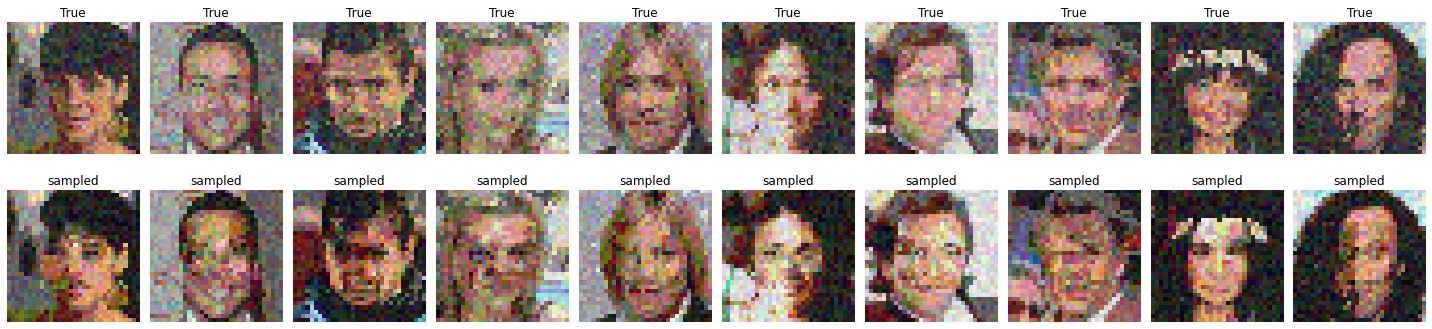

In [23]:
x=next(iter(test_loader)).to(device)

#Preprocess
x_cont, _ = solver.preprocess(x, dequantize=True)
con_x, x_cont = x_cont.split(3,dim=1)

#Sample from distribution
prior = torch.distributions.Normal(torch.tensor(0.).to(device), torch.tensor(1.).to(device))
z = prior.sample([64, 3, 32, 32])

with torch.no_grad():
  samples=solver.flow.g(z.to(device), con_x.to(device))

# Preprocess samples
samples=solver.preprocess(samples, dequantize=False, reverse=True)

# Our true values
conzre=solver.preprocess(con_x, dequantize=False, reverse=True)
zre=solver.preprocess(x_cont, dequantize=False, reverse=True)

fig, axes = plt.subplots(2, 10 , figsize = (20,5))

j=0
k=0
for i in range(0, 10):
  img_1 = ((conzre[i]+zre[i])/4*4)
  axes[k*2, j].imshow(img_1.div(img_1.max()).permute(1,2,0).detach().cpu().numpy())
  axes[k*2, j].set_title('True')
  axes[k*2, j].set_axis_off()
  kk = conzre[i]/4*4
  kk[:,8:24,8:24]=samples[i][:,8:24,8:24]
  axes[k*2+1, j].imshow((kk.div(kk.max())).permute(1,2,0).detach().cpu().numpy())
  axes[k*2+1, j].set_title('sampled')
  axes[k*2+1, j].set_axis_off()
  k+=1
  if k*2 % 2 == 0:
    j += 1
    k = 0

fig.tight_layout()